# 05 — Inference on Test Images

This notebook demonstrates how the trained U-Net model can be used to perform inference on unseen satellite images.

The goal is to:
- Load the trained segmentation model
- Run predictions on test images
- Visualize predicted land-cover maps
- (Optionally) save predictions for later analysis

This step demonstrates real-world usability of the trained model.

In [1]:
# Imports and paths
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Paths
Paths are defined relative to the project root to ensure portability.

In [2]:
# Project root is parent of notebooks/
PROJECT_ROOT = Path.cwd().parent

MODEL_PATH = PROJECT_ROOT / "models" / "unet_deepglobe.pth"
TEST_DIR   = PROJECT_ROOT / "data" / "raw" / "test"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "test_predictions"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

assert MODEL_PATH.exists(), "Model file not found"
assert TEST_DIR.exists(), "Test directory not found"

print("Paths verified.")

Paths verified.


## Model Definition (Exact Training Version)
The U-Net architecture below is identical to the model used during training. This is required to correctly load the saved weights.

In [3]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(3, 64)
        self.enc2 = block(64, 128)
        self.enc3 = block(128, 256)
        self.enc4 = block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = block(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b  = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)

## Load Trained Model
The trained model is loaded and set to evaluation mode.

In [4]:
model = UNet(num_classes=7).to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\ibaan\AppData\Local\Temp\ipykernel_23416\444802190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


## Test Images
Test images do not have ground truth masks.
Predictions are generated purely for inference and visualization.

In [5]:
test_images = sorted([f for f in TEST_DIR.iterdir() if f.suffix.lower() == ".jpg"])
print("Test images found:", len(test_images))

Test images found: 172


## Inference Function
Each test image is passed through the model to generate a pixel-wise
land-cover prediction.

In [6]:
def run_inference(image_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    input_tensor = torch.tensor(
        image / 255.0, dtype=torch.float32
    ).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    return image, prediction

## Visualize Predictions
Predicted segmentation maps are visualized alongside the original
satellite images.

In [7]:
def visualize_inference(idx=0):
    image_path = test_images[idx]
    image, pred = run_inference(image_path)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title("Satellite Image")

    axs[1].imshow(pred)
    axs[1].set_title("Predicted Segmentation")

    for ax in axs:
        ax.axis("off")

    plt.show()

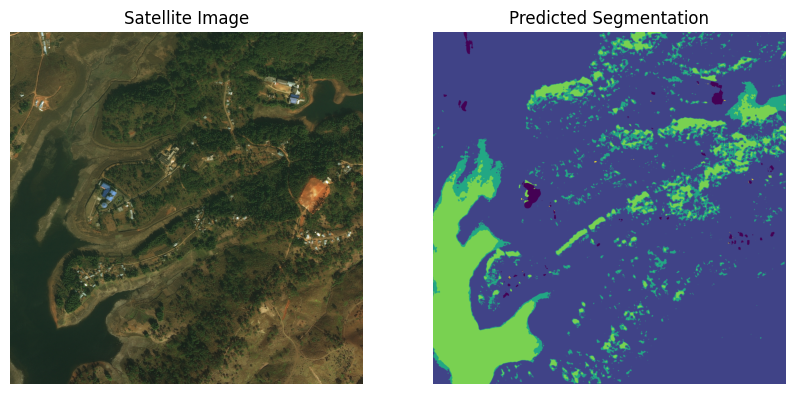

In [8]:
visualize_inference(0)

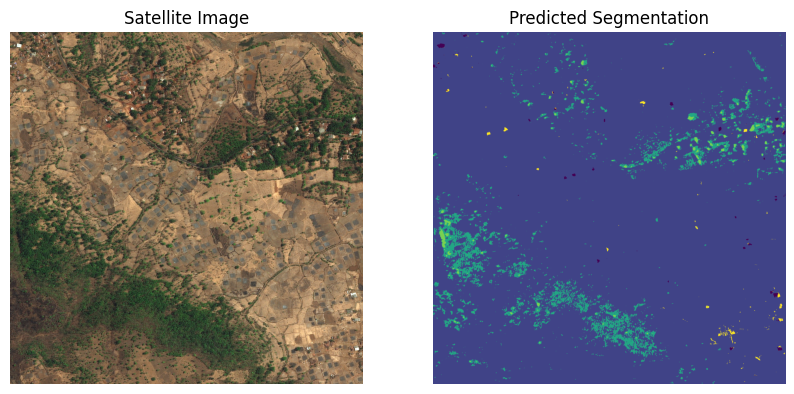

In [9]:
visualize_inference(5)

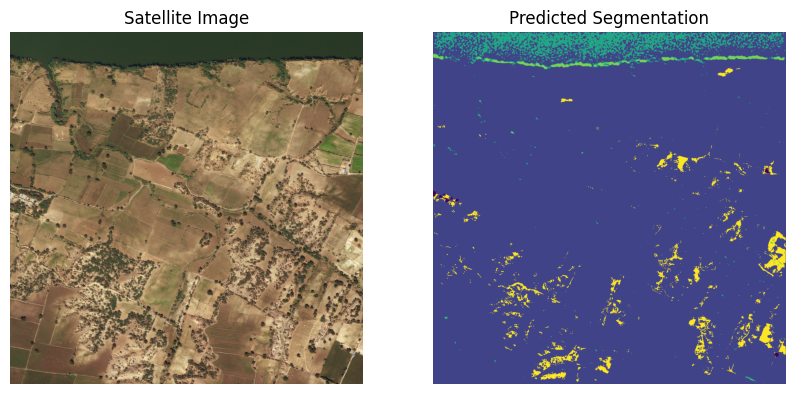

In [11]:
visualize_inference(27)

## Save predictions
Predicted segmentation masks can be saved to disk for later analysis or visualization.

In [12]:
for img_path in tqdm(test_images):
    _, pred = run_inference(img_path)
    out_path = OUTPUT_DIR / f"{img_path.stem}_pred.npy"
    np.save(out_path, pred)

print("All test predictions saved.")

100%|██████████| 172/172 [3:21:00<00:00, 70.12s/it]  

All test predictions saved.


## Saving Colored Prediction Images

To make the segmentation results human-readable, predicted class maps are converted into color-coded PNG images using the official DeepGlobe land-cover color scheme.


In [13]:
# DeepGlobe class color mapping (RGB)
CLASS_COLORS = {
    0: (0, 255, 255),     # Urban land
    1: (255, 255, 0),     # Agriculture land
    2: (255, 0, 255),     # Rangeland
    3: (0, 255, 0),       # Forest land
    4: (0, 0, 255),       # Water
    5: (255, 255, 255),  # Barren land
    6: (0, 0, 0)          # Unknown
}

In [14]:
def mask_to_color(mask, color_map):
    """
    Convert a 2D class mask to a color RGB image.
    """
    h, w = mask.shape
    color_image = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in color_map.items():
        color_image[mask == class_id] = color

    return color_image

In [15]:
COLOR_OUTPUT_DIR = PROJECT_ROOT / "outputs" / "test_predictions_png"
COLOR_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for pred_file in tqdm(OUTPUT_DIR.glob("*.npy")):
    # Load prediction
    pred_mask = np.load(pred_file)

    # Convert to color image
    color_pred = mask_to_color(pred_mask, CLASS_COLORS)

    # Save as PNG
    out_path = COLOR_OUTPUT_DIR / f"{pred_file.stem}.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(color_pred, cv2.COLOR_RGB2BGR))

print("Colored PNG predictions saved.")

172it [00:48,  3.57it/s]

Colored PNG predictions saved.
